# Streaming Responses from the Workflow/Graph

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import SystemMessage,HumanMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from dotenv import load_dotenv
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

load_dotenv()

True

Creating the SQLIte Connection

In [2]:
import os
import aiosqlite

os.makedirs("db", exist_ok=True)

path = os.path.join(os.getcwd(), "db", "streaming.db")
connection = aiosqlite.connect(path,check_same_thread=False)

Using the Code from the previously created chat history

In [3]:
llm_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", temperature=0, thinking_budget=0)

memory = AsyncSqliteSaver(connection)


class State(MessagesState):
    intent: str


def call_model(state: State) -> State:
    system_message = SystemMessage(
        "You are a helpful Assistant. Which replies to user queries"
    )
    response = llm_model.invoke([system_message] + state["messages"])
    return {"messages": [response]}


def determine_call(state: State) -> State:
    system_message = SystemMessage("""What user is trying to ask reply either from the below options if the asked reply is in - Question - Information - None""")
    response = llm_model.invoke([system_message]+[state["messages"][-1]])
    return {
        "intent": response.content
    }


graph = StateGraph(State)
graph.add_node("model", call_model)
graph.add_node("intent", determine_call)

graph.add_edge(START, "intent")
graph.add_edge("intent", "model")
graph.add_edge("model", END)

agent = graph.compile(memory, name="simple_agent")

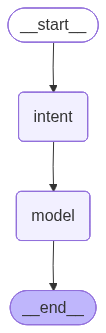

In [4]:
from IPython.display import display,Image

display(Image(agent.get_graph().draw_mermaid_png()))

Invoking the Agent or Graph with Streaming

- updates - streams the `updates` to the state after each step of the graph.

In [5]:
config = {"configurable": {"thread_id": "10"}}

# Start conversation
async for chunk in agent.astream({"messages": [HumanMessage(content="do you have feelings?")]}, config, stream_mode="updates"):
    print(chunk)

{'intent': {'intent': '* **Question:** This is a direct question about my internal state.'}}
{'model': {'messages': [AIMessage(content="No, I don't have feelings. I am an artificial intelligence, a computer program. I don't have a consciousness, emotions, or subjective experiences like humans do.\n\nMy responses are generated based on the vast amount of text data I've been trained on, allowing me to understand and generate human-like language. I can process information about emotions and even discuss them, but I don't personally feel them. I don't experience joy, sadness, anger, love, or any other emotion.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--ef26213c-c667-49db-a3cf-72c553923031-0', usage_metadata={'input_tokens': 945, 'output_tokens': 105, 'total_tokens': 1050, 'input_token_details': {'cache_

- values - streams the fulll value of the state after each step of the graph

In [7]:
config = {"configurable": {"thread_id": "10"}}

# Start conversation
async for chunk in agent.astream({"messages": [HumanMessage(content="can you dance?")]}, config, stream_mode="updates"):
    print(chunk)

{'intent': {'intent': 'Information'}}
{'model': {'messages': [AIMessage(content="No, I cannot dance. I don't have a physical body, limbs, or the ability to move in the way a human or even a robot can. I exist as code and data on computer servers.\n\nWhile I can process information about dance, describe different dance styles, or even generate text about someone dancing, I can't physically perform the act myself.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7b6d3581-a78d-4df2-a158-22b61f31bcb2-0', usage_metadata={'input_tokens': 1056, 'output_tokens': 75, 'total_tokens': 1131, 'input_token_details': {'cache_read': 0}})]}}


Stream Messages


In [9]:
config = {"configurable": {"thread_id": "10"}}

# Start conversation
async for chunk in agent.astream({"messages": [HumanMessage(content="can you dance?")]}, config, stream_mode="messages"):
    print(chunk)

(AIMessageChunk(content='Information', additional_kwargs={}, response_metadata={'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7f06b60d-83eb-436a-ba53-4dde2a5fcc4a', usage_metadata={'input_tokens': 29, 'output_tokens': 1, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}), {'thread_id': '10', 'langgraph_step': 45, 'langgraph_node': 'intent', 'langgraph_triggers': ('branch:to:intent',), 'langgraph_path': ('__pregel_pull', 'intent'), 'langgraph_checkpoint_ns': 'intent:48f26034-46cc-7933-800c-63e43e2e6159', 'checkpoint_ns': 'intent:48f26034-46cc-7933-800c-63e43e2e6159', 'ls_provider': 'google_genai', 'ls_model_name': 'gemini-2.5-flash', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7f06b60d-83eb-436a-ba53-4dde2a5fcc4a', usage_metadata={'total_tokens': 0, 'inp

Stream Events

In [8]:
config = {"configurable": {"thread_id": "10"}}

# Start conversation
async for chunk in agent.astream_events({"messages": [HumanMessage(content="can you dance?")]}, config, stream_mode="messages"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='can you dance?', additional_kwargs={}, response_metadata={})]}}, 'name': 'simple_agent', 'tags': [], 'run_id': '2a3bf67b-2483-4180-86eb-e64368fcde73', 'metadata': {'thread_id': '10'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='do you have feelings?', additional_kwargs={}, response_metadata={}, id='0f035958-fab0-4f52-8c2e-ff8627e6fb92'), AIMessage(content="As an AI, I don't experience feelings in the same way humans do. I don't have a brain with emotions, hormones, or personal experiences that shape feelings like joy, sadness, anger, or love.\n\nInstead, I can process and understand information about human emotions, and even generate text that expresses or describes them. I can recognize patterns in language that indicate certain feelings, and I can learn to respond in ways that are helpful or appropriate in emotional contexts.\n\nSo, while I can tal

Stream Multiple

In [14]:
config = {"configurable": {"thread_id": "09"}}

# Start conversation
async for chunk in agent.astream({"messages": [HumanMessage(content="can you dance?")]}, config, stream_mode=["messages","values","updates"]):
    print(chunk)

('values', {'messages': [HumanMessage(content='can you dance?', additional_kwargs={}, response_metadata={}, id='c1f72c94-f70d-40ed-8cd9-5fd5393dfafa')]})
('messages', (AIMessageChunk(content='Information', additional_kwargs={}, response_metadata={'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7ddcdb18-aec0-43bd-a3db-2e2c39a8edd7', usage_metadata={'input_tokens': 29, 'output_tokens': 1, 'total_tokens': 30, 'input_token_details': {'cache_read': 0}}), {'thread_id': '09', 'langgraph_step': 1, 'langgraph_node': 'intent', 'langgraph_triggers': ('branch:to:intent',), 'langgraph_path': ('__pregel_pull', 'intent'), 'langgraph_checkpoint_ns': 'intent:34578837-0613-3288-fcf7-85bc2d84acc2', 'checkpoint_ns': 'intent:34578837-0613-3288-fcf7-85bc2d84acc2', 'ls_provider': 'google_genai', 'ls_model_name': 'gemini-2.5-flash', 'ls_model_type': 'chat', 'ls_temperature': 0.0}))
('messages', (AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', '